# PRÀCTICA 2 - Neteja i anàlisi de les dades

In [1]:
# Importem llibreries
import os
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.manifold import TSNE

# 0. Selecció del dataset

El dataset triat per a aquesta pràctica es diu: **European Soccer Data** i es pot trobar en aquest [link](https://data.world/data-society/european-soccer-data). En aquesta pràctica el trobarem dins del directori `.\data\soccer_database.sqlite` i l'haurem d'haver descarregat previament.

In [2]:
# Agafem el dataset del nostre repository 
folder = os.getcwd() + '\data\\'

# 1. Descripció del dataset. Perquè és important i quina pregunta/problema pretén respondre?

Ens trobem davant un dataset amb dades detallades sobre més de **25.000 partits de futbol a les lligues professionals d'Europa**. Aquest dataset inclou informació sobre els equips de cada país, els seus jugadors, dades de les temporades 2008 a 2016 i informació detallada de cada partit (marcador, possesió, faltes, corners, targetes, ...). Tot això ho tenim recollit en les següents taules:
* **Country:** Pais europeu.
* **League:** nom de la lliga de cada pais.
* **Match:** dades detallades de cada partit
* **Player:** descripció del jugador amb dades com l'edat, altura i pes.
* **Player_Attributes:** característiques especifiques de cada jugador com posició de joc, puntuació de les seves habilitats, etc.
* **Team:** descripció dels equips.
* **Team_Attributes:** característiques especifiques de cada equip com el tipus de formació en atac o defensa.

Comentar que les dades dels atributs que tenim sobre els equips i els jugadors estan extrets del videojoc FIFA ([http://sofifa.com](http://sofifa.com)), per complementar la informació original.

També es pot arrivar a visualitzar la posició al camp dels jugadors gràcies als atributs amb les coordenades X i Y, per si volguessim representar gràficament les posicions.

Gràcies a la gran quantitat d'informació que tenim amb aquest dataset podem arribar a fer molts tipus d'analisis diferents. Els que hem decidit fer són:

* Classificacions de les lligues per temporada
* Considerant les principals lligues, hi ha diferències entre els equips de cada quartil de la classifiació al final de cada temporada? (Contrast d'hipotesi)
* Hi ha alguna relació entre la mitjana de punts per partit i la qualitat de l'equip? (Regressió linial)
* Podem trobar jugadors joves amb les mateixes qualitats o semblants a algunes de les estrelles del futbol? (Agrupació)
* Podem construir un model per fer prediccions de victories? (Arbre de desició)



# 2. Integració i selecció de les dades d’interès a analitzar.

En aquest apartat realitzarem la preparació de les dades, seleccionant les dades que necessitarem del dataset original per realitzar els anàlisis posteriors i construcció de models predictius.

In [3]:
# Carreguem les dades en dataframes separats per la seva posterior utilització
conn = sqlite3.connect(folder + 'soccer_database.sqlite')
query_country = 'SELECT id, name FROM Country'
query_league = 'SELECT id, country_id, name FROM League'
query_match = 'SELECT id, country_id, league_id, season, stage, date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal, home_player_X1, home_player_X2, home_player_X3, home_player_X4, home_player_X5, home_player_X6, home_player_X7, home_player_X8, home_player_X9, home_player_X10, home_player_X11, away_player_X1, away_player_X2, away_player_X3, away_player_X4, away_player_X5, away_player_X6, away_player_X7, away_player_X8, away_player_X9, away_player_X10, away_player_X11, home_player_Y1, home_player_Y2, home_player_Y3, home_player_Y4, home_player_Y5, home_player_Y6, home_player_Y7, home_player_Y8, home_player_Y9, home_player_Y10, home_player_Y11, away_player_Y1, away_player_Y2, away_player_Y3, away_player_Y4, away_player_Y5, away_player_Y6, away_player_Y7, away_player_Y8, away_player_Y9, away_player_Y10, away_player_Y11, home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11, goal, shoton, shotoff, foulcommit, card, cross, corner, possession, B365H, B365D, B365A, BWH, BWD, BWA, IWH, IWD, IWA, LBH, LBD, LBA, PSH, PSD, PSA, WHH, WHD, WHA, SJH, SJD, SJA, VCH, VCD, VCA, GBH, GBD, GBA, BSH, BSD, BSA FROM Match'
query_player = 'SELECT id, player_api_id, player_name, player_fifa_api_id, birthday, height, weight FROM Player'
query_player_attributes = 'SELECT id, player_fifa_api_id, player_api_id, date, overall_rating, potential, preferred_foot, attacking_work_rate, defensive_work_rate, crossing, finishing, heading_accuracy, short_passing, volleys, dribbling, curve, free_kick_accuracy, long_passing, ball_control, acceleration, sprint_speed, agility, reactions, balance, shot_power, jumping, stamina, strength, long_shots, aggression, interceptions, positioning, vision, penalties, marking, standing_tackle, sliding_tackle, gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes FROM Player_Attributes'
query_team = 'SELECT id, team_api_id, team_fifa_api_id, team_long_name, team_short_name FROM Team'
query_team_attributes = 'SELECT id, team_fifa_api_id, team_api_id, date, buildUpPlaySpeed, buildUpPlaySpeedClass, buildUpPlayDribbling, buildUpPlayDribblingClass, buildUpPlayPassing, buildUpPlayPassingClass, buildUpPlayPositioningClass, chanceCreationPassing, chanceCreationPassingClass, chanceCreationCrossing, chanceCreationCrossingClass, chanceCreationShooting, chanceCreationShootingClass, chanceCreationPositioningClass, defencePressure, defencePressureClass, defenceAggression, defenceAggressionClass, defenceTeamWidth, defenceTeamWidthClass, defenceDefenderLineClass FROM Team_Attributes'

df_country = pd.read_sql_query(query_country, conn)
df_league = pd.read_sql_query(query_league, conn)
df_match = pd.read_sql_query(query_match, conn)
df_player = pd.read_sql_query(query_player, conn)
df_player_attributes = pd.read_sql_query(query_player_attributes, conn)
df_team = pd.read_sql_query(query_team, conn)
df_team_attributes = pd.read_sql_query(query_team_attributes, conn)
conn.close()

Aquests Dataframes els utilitzarem com a base per realitzar els anàlisis, les tasques de neteja, revisió de valors buits i identificació de valors extrems.

## 2.1 Càlcul de classificacions


Una de les respostes que volem respondre és quina diferència hi ha entre els equips de cada part quartil de la classificació per a diferents lligues i al final de cada temporada. 

Per a fer això, extraurem els resultat de cada partit del Dataframe df_match, assignarem punts a cada equip, i agregarem els punts de cada equip per a cada temporada.

A més, en cas d'empat de punts, és donarà una posició més alta a aquells equips amb major diferència de gols i, posteriorment, amb més gols a favor.

In [4]:
df_match_to_classification = df_match[['league_id','season', 'stage',
          'home_team_api_id','away_team_api_id',
          'home_team_goal','away_team_goal']].copy()
df_match_to_classification['home_team'] = df_match_to_classification['home_team_api_id'].replace(
    df_team[['team_api_id','team_long_name']].set_index('team_api_id').to_dict()['team_long_name']
)
df_match_to_classification['away_team'] = df_match_to_classification['away_team_api_id'].replace(
    df_team[['team_api_id','team_long_name']].set_index('team_api_id').to_dict()['team_long_name']
)
df_match_to_classification['league_name'] = df_match_to_classification['league_id'].replace(
    df_league[['id','name']].set_index('id').to_dict()['name']
)
df_match_to_classification['away_team_goal_against'] = df_match_to_classification['home_team_goal']
df_match_to_classification['home_team_goal_against'] = df_match_to_classification['away_team_goal']
df_match_to_classification = df_match_to_classification[['season', 'league_name', 'home_team', 'away_team', 
                            'home_team_goal', 'away_team_goal', 'away_team_goal_against', 
                            'home_team_goal_against']]

In [5]:
df_match_to_classification.loc[df_match_to_classification['home_team_goal'] >  df_match_to_classification['away_team_goal'], 'home_points'] = 3
df_match_to_classification.loc[df_match_to_classification['home_team_goal'] >  df_match_to_classification['away_team_goal'], 'away_points'] = 0
df_match_to_classification.loc[df_match_to_classification['home_team_goal'] == df_match_to_classification['away_team_goal'], 'home_points'] = 1
df_match_to_classification.loc[df_match_to_classification['home_team_goal'] == df_match_to_classification['away_team_goal'], 'away_points'] = 1
df_match_to_classification.loc[df_match_to_classification['home_team_goal'] <  df_match_to_classification['away_team_goal'], 'home_points'] = 0
df_match_to_classification.loc[df_match_to_classification['home_team_goal'] <  df_match_to_classification['away_team_goal'], 'away_points'] = 3

In [6]:
df_classification = df_match_to_classification[['season','league_name','home_team','home_team_goal','home_team_goal_against','home_points']].rename(
    columns={
        'home_team':'team',
        'home_team_goal':'goals',
        'home_team_goal_against':'goals_against',
        'home_points':'points'
    }
).append(
    df_match_to_classification[['season','league_name','away_team','away_team_goal','away_team_goal_against','away_points']].rename(
    columns={
        'away_team':'team',
        'away_team_goal':'goals',
        'away_team_goal_against':'goals_against',
        'away_points':'points'
    }
)
)
df_classification['matches'] = 1
df_classification = df_classification.groupby(['season','league_name','team']).sum().reset_index()
df_classification['dif_goals'] = df_classification['goals'] - df_classification['goals_against']
df_classification = df_classification.sort_values(['season','league_name','points','dif_goals','goals'], 
                                                  ascending=[True,True, False,False,False])
df_classification['pos'] = 1
df_classification['pos'] = df_classification.groupby(['season', 'league_name'])['pos'].cumsum()
df_classification

,season,league_name,team,goals,goals_against,points,matches,dif_goals,pos
11,2008/2009,Belgium Jupiler League,RSC Anderlecht,75,30,77.0,34,45,1
16,2008/2009,Belgium Jupiler League,Standard de Liège,66,26,77.0,34,40,2
3,2008/2009,Belgium Jupiler League,KAA Gent,67,42,59.0,34,25,3
1,2008/2009,Belgium Jupiler League,Club Brugge KV,59,50,59.0,34,9,4
13,2008/2009,Belgium Jupiler League,SV Zulte-Waregem,55,36,55.0,34,19,5
...,...,...,...,...,...,...,...,...,...
1473,2015/2016,Switzerland Super League,FC Thun,45,54,41.0,36,-9,6
1472,2015/2016,Switzerland Super League,FC St. Gallen,41,66,38.0,36,-25,7
1474,2015/2016,Switzerland Super League,FC Vaduz,44,60,36.0,36,-16,8
1477,2015/2016,Switzerland Super League,Lugano,46,75,35.0,36,-29,9


## 2.2 Mitjana dels jugadors per a cada equip i temporada


A més, voldrem comparar els ratings dels equips basat en la puntuacuó mitjana de cada jugador per a cada una de les temporades analitzades. El repte és que cada jugador pot tenir més d'una puntuació per a una mateixa temporada. Per tant, haurem de seguir el següent procés:

1.   Identificar a quin mes comença i finalitza cada temporada.
2.   Basant-nos en aquestes dades, associarem cada data en la qual se li va otorgar una nova puntuació a un jugador amb la corresponent temporada.
3. Farem la puntuació mitjana per a cada jugador i temporada.
4. Calcularem la puntuació de cada equip basant-nos en la mitjana ponderada de la puntuació dels jugadors, on el pes és el nombre de partits jugats de cada jugador.

In [7]:
# Comprovem les dades màximes i mínimes de cada temporada
df_match.groupby('season').agg({'date':['min','max']})

date                     
                           min                  max
season                                             
2008/2009  2008-07-18 00:00:00  2009-05-31 00:00:00
2009/2010  2009-07-11 00:00:00  2010-05-16 00:00:00
2010/2011  2010-07-17 00:00:00  2011-05-29 00:00:00
2011/2012  2011-07-16 00:00:00  2012-05-23 00:00:00
2012/2013  2012-07-13 00:00:00  2013-06-02 00:00:00
2013/2014  2013-07-13 00:00:00  2014-05-18 00:00:00
2014/2015  2014-07-18 00:00:00  2015-05-31 00:00:00
2015/2016  2015-07-17 00:00:00  2016-05-25 00:00:00

Podem assegurar que la temporada a totes les lligues està compresa entre l'1 de Juliol i el 30 de Juny. 
seguidament, mapegem les temporades a la taula dels ratings dels jugadors, i calculem la mitjana de cada jugador.

In [8]:
df_ratings = df_player_attributes[['player_api_id', 'date', 'overall_rating']].copy()
df_ratings['date'] = pd.to_datetime(df_ratings['date'])
idx_beggining = df_ratings[df_ratings['date'].dt.month >= 7].index
idx_end = df_ratings[df_ratings['date'].dt.month < 7].index

df_ratings.loc[idx_beggining, 'season'] = df_ratings.loc[idx_beggining, 'date'].dt.year.astype(str) + '/' + (df_ratings.loc[idx_beggining, 'date'].dt.year + 1).astype(str)
df_ratings.loc[idx_end, 'season'] = (df_ratings.loc[idx_end, 'date'].dt.year - 1).astype(str) + '/' + df_ratings.loc[idx_end, 'date'].dt.year.astype(str)
df_ratings_season = df_ratings.groupby(['player_api_id','season'], as_index=False)[['overall_rating']].mean()
df_ratings_season.head()

,player_api_id,season,overall_rating
0,2625,2006/2007,63.0
1,2625,2007/2008,63.0
2,2625,2008/2009,60.0
3,2625,2010/2011,59.5
4,2625,2011/2012,58.0


Per a cada equip i temporada, comptabilitzem les aparicions de cada jugador. Comptem els nuls.

In [9]:
df_match_players = df_match[['season', 'stage',
                             'home_team_api_id','away_team_api_id',
          'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 
          'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',  
          'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 
          'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11'
          ]].copy()
df_match_players['home_team'] = df_match_players['home_team_api_id'].replace(
    df_team[['team_api_id','team_long_name']].set_index('team_api_id').to_dict()['team_long_name']
)
df_match_players['away_team'] = df_match_players['away_team_api_id'].replace(
    df_team[['team_api_id','team_long_name']].set_index('team_api_id').to_dict()['team_long_name']
)

In [10]:
df_match_players = df_match_players[['season', 'stage','home_team'] + [x for x in df_match_players if 'home_player' in x]].rename(
    columns = {
        x:x[5:] for x in df_match_players.columns if 'home' in x
    }
).append(
    df_match_players[['season', 'stage','away_team'] + [x for x in df_match_players if 'away_player' in x]].rename(
    columns = {
        x:x[5:] for x in df_match_players.columns if 'away' in x
    }
)
).set_index(['season','stage','team'])

df_match_unstacked = pd.DataFrame()
for col in df_match_players.columns:
  df_match_unstacked = df_match_unstacked.append(df_match_players[[col]].rename(columns={col:'player_api_id'}))
df_match_unstacked = df_match_unstacked.reset_index()

df_match_unstacked_rating = df_match_unstacked.merge(df_ratings_season[['player_api_id','overall_rating','season']],
                       on=['player_api_id','season'], 
                       how='left')

df_appear = df_match_unstacked_rating.groupby(['season','team','player_api_id'], as_index=False)['overall_rating'].count().rename(columns={'overall_rating':'appearences'})
df_player_rating_appearences = df_match_unstacked_rating.groupby(['season','team','player_api_id'], as_index=False)['overall_rating'].mean().merge(
    df_appear, on=['season', 	'team', 	'player_api_id'], how='left')

df_player_rating_appearences.head()

,season,team,player_api_id,overall_rating,appearences
0,2008/2009,1. FC Köln,23628.0,73.0,18
1,2008/2009,1. FC Köln,26173.0,75.5,31
2,2008/2009,1. FC Köln,27255.0,60.0,3
3,2008/2009,1. FC Köln,27550.0,69.0,17
4,2008/2009,1. FC Köln,30789.0,78.5,31


Finalment, obtenim la puntuació per a cada equip i temporada.

In [11]:
df_player_rating_appearences = df_player_rating_appearences.merge(
    df_player_rating_appearences.groupby(['season','team'], as_index=False)['appearences'].sum(),
    on=['season','team'],
    how='left',
    suffixes=('','_total')
)

In [12]:
df_player_rating_appearences['weighed_rating'] = (
    df_player_rating_appearences['overall_rating'] * df_player_rating_appearences['appearences'] / 
    df_player_rating_appearences['appearences_total']
)
df_season_team_rating = df_player_rating_appearences.groupby(
    ['season','team'], 
    as_index=False)[['weighed_rating']].sum()
df_season_team_rating.head()

,season,team,weighed_rating
0,2008/2009,1. FC Köln,70.836898
1,2008/2009,AC Bellinzona,58.012346
2,2008/2009,ADO Den Haag,63.381356
3,2008/2009,AJ Auxerre,69.476250
4,2008/2009,AS Monaco,69.873206


# 3. Neteja de les dades.


## 3.1. Les dades contenen zeros o elements buits? Com gestionaries aquests casos?


Les dades utilitzades en aquesta pràctica són força netes. No obstant, hem observat que per als atributs dels jugadors, alguns d'aquests aparèixen com a nuls.

In [13]:
df_player_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

Tenim registres on tots els atributs son nulls (836 registres) i en altres casos es nomes en alguns atributs.
És el cas, per exemple, dels atributs *sliding_takle*, *agility*, *vision*, *jumping*, *balance*, *volleys*, o *agility*. Això és degut a que el videojoc FIFA va incloure aquests atributs durant les temporades que s'abarquen en aquest estudi.

Una opció per a tracar la manca de dades seria la de no utilitzar aquestes variables. No obstant, degut a que no suposen un gran nombre i que aquestes són dades quantitatives, s'ha optat per utilitzar el mètode *imperative imputer* de la llibreria Sklearn de Python. Aquest mètode estima el valor de cada variabla nul·la a partir de totes les altres variables, construint, en cada cas, un model de regresió lineal.

In [14]:
# inputem valors nuls 
df_player_attributes_imputed = df_player_attributes.set_index('player_api_id').iloc[:,8:]
imp = IterativeImputer(max_iter=10, random_state=0)
df_player_attributes_imputed = pd.DataFrame(imp.fit_transform(df_player_attributes_imputed),
                                            columns=df_player_attributes_imputed.columns,
                                            index=df_player_attributes_imputed.index
                                            )

In [15]:
# valors abans d'imputar
df_player_attributes.describe()['sliding_tackle']

count    181265.000000
mean         48.001462
std          21.598778
min           2.000000
25%          25.000000
50%          53.000000
75%          67.000000
max          95.000000
Name: sliding_tackle, dtype: float64

In [16]:
# valors despres d'imputar
df_player_attributes_imputed.describe()['sliding_tackle']

count    183978.000000
mean         48.025980
std          21.529759
min           2.000000
25%          25.000000
50%          53.000000
75%          67.000000
max          95.000000
Name: sliding_tackle, dtype: float64

Amb tots els atributs omplerts podem afegir les especificacions comuns amb les que es representen les caracteristiques dels jugadors al joc FIFA.

In [17]:
# Font: https://sofifa.com/player/176580/luis-suarez/160006/?attr=fut
df_player_attributes_imputed['pac'] = df_player_attributes_imputed[['acceleration','sprint_speed']].mean(axis=1)
df_player_attributes_imputed['sho'] = df_player_attributes_imputed[['positioning','finishing','shot_power','long_shots','volleys','penalties']].mean(axis=1)
df_player_attributes_imputed['pas'] = df_player_attributes_imputed[['vision','crossing','free_kick_accuracy','short_passing','long_passing','curve']].mean(axis=1)
df_player_attributes_imputed['dri'] = df_player_attributes_imputed[['agility','balance','reactions','ball_control','dribbling']].mean(axis=1)
df_player_attributes_imputed['def'] = df_player_attributes_imputed[['interceptions','heading_accuracy','marking','standing_tackle','sliding_tackle']].mean(axis=1)
df_player_attributes_imputed['phy'] = df_player_attributes_imputed[['jumping','stamina','strength','aggression']].mean(axis=1)

## 3.2. Identificació i tractament de valors extrems.


Un altre dels problemes identificats és que no es disposen de tots els partits per a totes les lligues i temporades. Per tant, s'han identificat en quins casos el nombre de jornades és menor a l'esperat i, en aquest cas, s'han elimitats aquelles temporades i lligues que no contenen un mínim de partits.

{'whiskers': [<matplotlib.lines.Line2D at 0x1e464208f48>,
 'caps': [<matplotlib.lines.Line2D at 0x1e459970c88>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e464208c48>],
 'medians': [<matplotlib.lines.Line2D at 0x1e45995de08>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e45995df08>],
 'means': []}

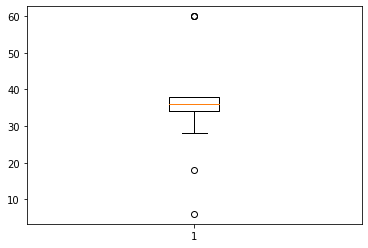

In [18]:
plt.boxplot(df_classification[['season','league_name','matches']].drop_duplicates()['matches'])

En el diagrame de caixes veiem que hi ha casos en el que el nombre de partits és menor de 30 o major de 40. En aquest cas, eliminarem de les dades aquestes lligues i temporades.

In [19]:
df_classification[['season','league_name','matches']].drop_duplicates()[
 (df_classification[['season','league_name','matches']].drop_duplicates()['matches'] < 30)
 |
 (df_classification[['season','league_name','matches']].drop_duplicates()['matches'] > 40)
]

,season,league_name,matches
124,2008/2009,Poland Ekstraklasa,60
196,2009/2010,Belgium Jupiler League,28
493,2010/2011,Poland Ekstraklasa,60
680,2011/2012,Poland Ekstraklasa,60
740,2011/2012,Switzerland Super League,18
929,2013/2014,Belgium Jupiler League,6


Veiem que la lliga suissa només va tenir 10 equips a la temporada 2011/2012 (https://en.wikipedia.org/wiki/2011%E2%80%9312_Swiss_Super_League), mentre que la lliga belga només en va tenir 15 a la temporada 2009/2010 (https://en.wikipedia.org/wiki/2009%E2%80%9310_Belgian_Pro_League), pel que considerarem aquests valors com a vàlids. La resta els considerarem outliers.

In [20]:
df_outliers = df_classification[['season','league_name','matches']].drop_duplicates()[
 (df_classification[['season','league_name','matches']].drop_duplicates()['matches'] < 18)
 |
 (df_classification[['season','league_name','matches']].drop_duplicates()['matches'] > 40)
]
df_outliers['dummy'] = 0

In [21]:
classification_outliers_idx = df_classification.merge(
    df_outliers.drop('matches', axis=1)
    , on=['season','league_name'],
how='left'
).dropna().index

In [22]:
df_classification_clean = df_classification.loc[[x for x in df_classification.index if x not in classification_outliers_idx]]

In [23]:
df_classification_clean.head()

,season,league_name,team,goals,goals_against,points,matches,dif_goals,pos
11,2008/2009,Belgium Jupiler League,RSC Anderlecht,75,30,77.0,34,45,1
16,2008/2009,Belgium Jupiler League,Standard de Liège,66,26,77.0,34,40,2
3,2008/2009,Belgium Jupiler League,KAA Gent,67,42,59.0,34,25,3
1,2008/2009,Belgium Jupiler League,Club Brugge KV,59,50,59.0,34,9,4
13,2008/2009,Belgium Jupiler League,SV Zulte-Waregem,55,36,55.0,34,19,5


# 4. Anàlisi de les dades.


## 4.1. Selecció dels grups de dades que es volen analitzar/comparar (planificació dels anàlisis a aplicar).


### 4.1.1 Preparació de les dades per a assignar el quartil de la classificació al qual correspon cada equip a final de temporada 

In [24]:
df_classification_grouped = df_classification_clean.groupby(
    ['season','league_name','team'], 
    as_index=False).sum()
df_classification_grouped['goals_diff'] = df_classification_grouped['goals'] - df_classification_grouped['goals_against']
df_classification_grouped = df_classification_grouped.sort_values(
        ['league_name', 'season','points','goals_diff','goals'], 
        ascending=[True, True, False, False, False]
        ).reset_index(drop=True)
df_classification_grouped = df_classification_grouped.merge(
    df_classification_grouped.groupby(['season','league_name'])[['team']].count().rename(columns={'team':'tot_teams'}),
    on=['season','league_name'],
    how='left')

df_classification_grouped['position'] = 1
df_classification_grouped['position'] = df_classification_grouped.groupby(['season','league_name'])['position'].cumsum()
df_classification_grouped['quart'] = df_classification_grouped['position']/df_classification_grouped['tot_teams']
df_classification_grouped.loc[
                              (df_classification_grouped['quart'] <= .25), 'quartile'] = 1
df_classification_grouped.loc[(df_classification_grouped['quart'] > .25)
                              &
                              (df_classification_grouped['quart'] <= .5), 'quartile'] = 2
df_classification_grouped.loc[(df_classification_grouped['quart'] > .5)
                              &
                              (df_classification_grouped['quart'] <= .75), 'quartile'] = 3
df_classification_grouped.loc[(df_classification_grouped['quart'] > .75), 'quartile'] = 4

Afegim la qualitat de l'equip per a cada temporada basant-nos en la mitjana ponderada de la qualitat dels jugadors que van jugar els partits durant una temporada donada i que hem calculat anteriorment al punt 2.2.

In [25]:
df_classification_rating = df_classification_grouped.merge(df_season_team_rating,
                                on=['season','team'],
                                how='left')

In [26]:
df_classification_rating.head()

,season,league_name,team,goals,goals_against,points,matches,dif_goals,pos,goals_diff,tot_teams,position,quart,quartile,weighed_rating
0,2008/2009,Belgium Jupiler League,RSC Anderlecht,75,30,77.0,34,45,1,45,18,1,0.055556,1.0,70.719008
1,2008/2009,Belgium Jupiler League,Standard de Liège,66,26,77.0,34,40,2,40,18,2,0.111111,1.0,69.055556
2,2008/2009,Belgium Jupiler League,KAA Gent,67,42,59.0,34,25,3,25,18,3,0.166667,1.0,66.238095
3,2008/2009,Belgium Jupiler League,Club Brugge KV,59,50,59.0,34,9,4,9,18,4,0.222222,1.0,68.458678
4,2008/2009,Belgium Jupiler League,SV Zulte-Waregem,55,36,55.0,34,19,5,19,18,5,0.277778,2.0,60.112500


## 4.2. Comprovació de la normalitat i homogeneïtat de la variància.


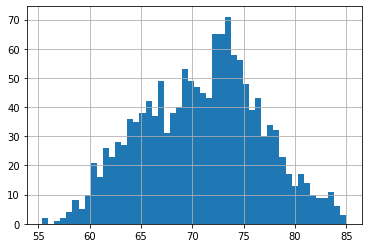

In [27]:
df_classification_rating['weighed_rating'].hist(bins=50)

In [28]:
from scipy import stats

_, p = stats.shapiro(df_classification_rating['weighed_rating'])
print(p)

5.269388339002035e-07


Podem afirmar que la mostra és normal amb més d'un 99.9% de confiança, ja que per al test de Shapiro-Wilk obtenim una $p-valor<.001$

Repetim el mateix anàlisi per a totes les lliges:

In [29]:
for league in df_classification_rating['league_name'].unique():
  df_temp_league = df_classification_rating[df_classification_rating['league_name']==league]
  print(league, stats.shapiro(df_temp_league['weighed_rating'])[1])

Belgium Jupiler League 0.26936089992523193
England Premier League 5.3012023272458464e-05
France Ligue 1 0.0004376452707219869
Germany 1. Bundesliga 0.005448274314403534
Italy Serie A 0.0420975461602211
Netherlands Eredivisie 0.00039530498906970024
Poland Ekstraklasa 0.9831841588020325
Portugal Liga ZON Sagres 1.449198236969096e-07
Scotland Premier League 1.4077383525545883e-07
Spain LIGA BBVA 9.7775965102187e-09
Switzerland Super League 0.16804847121238708


Mirem també els sis atributs creats per als jugadors:

C:\Users\Carlos\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


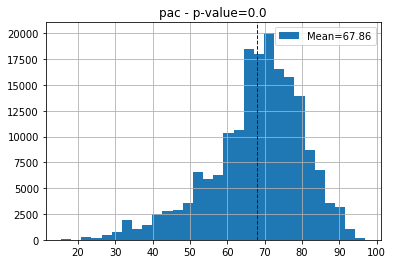

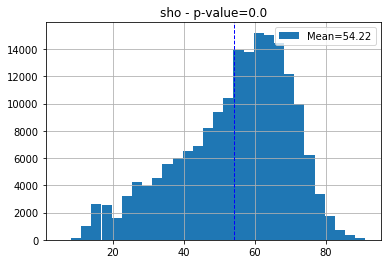

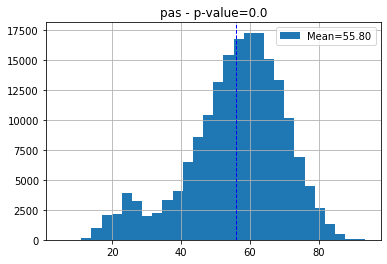

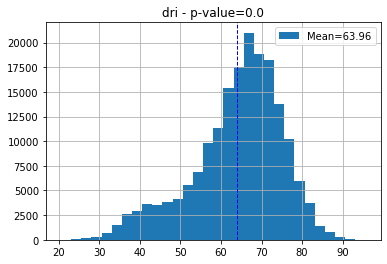

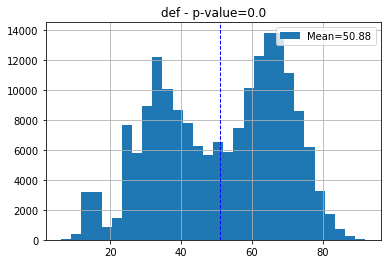

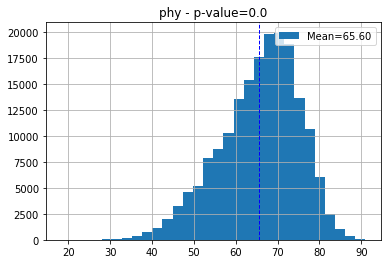

In [30]:
df_player_attributes_imputed
for qual in ['pac','sho','pas','dri','def','phy']:
  plt.figure()
  df_player_attributes_imputed[qual].hist(bins=30, label='Mean='+str("{:2.2f}".format(df_player_attributes_imputed[qual].mean())))
  plt.axvline(df_player_attributes_imputed[qual].mean(), color='blue', linestyle='dashed', linewidth=1)
  plt.title('{} - p-value={}'.format(qual, stats.shapiro(df_player_attributes_imputed[qual])[1]))
  plt.legend(loc='upper right')

Observem com per la puntuació mitja ponderada dels equips tenim una distribució normal a les dades. 
Sobre el test de Shapiro-Wilk realitzat sobre les lligues, podem destacar que les distribucions menys normals son les que corresponen per aquest ordre, a la lliga Polaca, Belga i Sueca.
Pel que fà als atributs dels jugadors, obtenim més freqüencia de casos per sobre de la mitjana en general. Destacar l'Histograma de l'atribut de la Defensa, on s'aprecia que els jugadors son generalment bons, o dolents defensivament.

## 4.3. Aplicació de proves estadístiques per comparar els grups de dades. En funció de les dades i de l’objectiu de l’estudi, aplicar proves de contrast d’hipòtesis, correlacions, regressions, etc. Aplicar almenys tres mètodes d’anàlisi diferents.


### 4.3.1 A les principals lligues, hi ha diferències entre els equips de cada quartil de la classificació al final de cada temporada?

Per a respondre aquesta pregunta, farem un contrast d'hipòtesis. 

Escrivim les nostres hipòtesis:

$H_{0}$: Per a les quatre lligues amb més qualitat, la qualitat dels equips de cada quartil de la classificació al final de temporada és diferent.

$H_{1}$: No hi ha diferències en la qualitat dels equips entre algun dels quartils.

En primera instància, visualitzem la distribució de la qualitat dels equips al llarg de totes les temporades per a les diferents lligues. Veiem com les lligues anglesa, alemana, espanyola i italiana són les que tenen equips amb més qualitat i, per tant, són les lligues que compararem per a respondre a la pregunta:

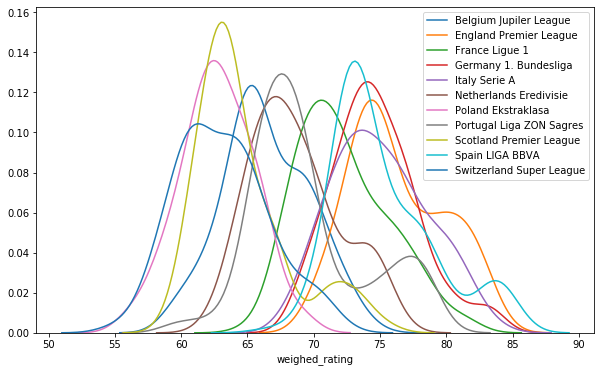

In [31]:
ax, fig = plt.subplots(1,figsize=(10,6))
for league in df_classification_rating['league_name'].unique():
  sns.distplot(df_classification_rating[df_classification_rating['league_name']==league]['weighed_rating'], hist=False, label=league)

Seleccionem les quatre lligues principals lligues i fem l'anàlisi de Tukey, per a cada lliga, comparants els equips de diferents quantils. L'anàlisi de Tuckey realitza anàlisis de variància comparant tots els grups individualment. D'aquesta manera, es pot saber si dos grups en particular són iguals o diferents, independentment de la similaritat amb els altres grups.

In [32]:
df_class_rat_4 = df_classification_rating[df_classification_rating['league_name'].isin(
    ['England Premier League','Germany 1. Bundesliga', 'Italy Serie A','Spain LIGA BBVA']
    )]
for num, country in enumerate(df_class_rat_4['league_name'].unique()):
  df_league = df_class_rat_4[df_class_rat_4['league_name'] == country]
  print('\n'+country+'\n')
  MultiComp = MultiComparison(df_league['weighed_rating'],
                            df_league['quartile'])
  print(MultiComp.tukeyhsd().summary())


England Premier League

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    2.0  -3.6446  0.001 -4.8387 -2.4506   True
   1.0    3.0  -6.6659  0.001   -7.86 -5.4719   True
   1.0    4.0  -7.2638  0.001 -8.4579 -6.0697   True
   2.0    3.0  -3.0213  0.001 -4.2154 -1.8272   True
   2.0    4.0  -3.6192  0.001 -4.8133 -2.4251   True
   3.0    4.0  -0.5979 0.5567  -1.792  0.5962  False
----------------------------------------------------

Germany 1. Bundesliga

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    2.0  -3.3639  0.001 -4.8323 -1.8954   True
   1.0    3.0  -4.7487  0.001 -6.2966 -3.2009   True
   1.0    4.0  -6.0341  0.001 -7.5025 -4.5656   True
   2.0    3.0  -1.3849 0.0723 -2.8533  0.0836  False
   2.0    4.0  -2.6702  0.001 -4.0547 -1.2858   Tr

L'anàlisi de Tuckey mostra amb un 95% de confiança que només podem rebutjar la hipòtesi nul·la per entre equips del tercer i quart quartil de les lligues anglesa, alemana i espanyola; i entre equips del segon i tercer quartil de la lliga alemana. 

Pel que fa la lliga italiana, els equips de tots els quartils són estadísticament diferents respecte als equips dels altres quartils de la classificació.

Si mirem la disctància total entre el primer i quart ($meandiff$), observem que la lliga espanyola és la que mostra més diferència, seguida per la lliga italiana, anglesa i alemana. Per tant, podem afirmar que la lliga espanyola ha estat la més desigual intre els anys 2008 i 2016. 

### 4.3.2 Correlació entre mitjana de punts per partit i qualitat de l'equip

Seguin amb la mateixa línea, volem saber si la puntuació dels equips respecte a la qualitat dels seus jugadors pot explicar la mitjana de punts per partit i, per tant, donar una idea de la posició en la classificació la qual es trobarà un equip a final de temporada. Per a estimar aquesta relació, construïm un model de regressió lineal. 

In [33]:
# Calculem els punts per partit
df_classification_rating.loc[:,'points_per_match'] = df_classification_rating['points']/df_classification_rating['matches']
df_class_rat_4.loc[:,'points_per_match'] = df_class_rat_4['points']/df_class_rat_4['matches']

C:\Users\Carlos\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Carlos\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


En primera instància, fem la regressió per a totes les lligues:

In [34]:
from scipy import stats

def mod(X,slope, intercept):
  return X * slope + intercept

slope, intercept, r_value, p_value, std_err = stats.linregress(df_classification_rating['weighed_rating'],
                                                               df_classification_rating['points_per_match'])
print('Totes les lligues: \n R2 = {}'.format(
    round(r_value**2,2)
))

Totes les lligues: 
 R2 = 0.24


El coeficient de determinació R$^{2}$, 0.24, indica una baixa correlacióó entre les dues variables. Aquest resultat probablement és degut a la desigualtat entre lligues a Europa. Per tant, un equip modest a una lliga secundària obtindrà un nombre alt de punts per partit; mentre que un equip amb la mateixa qualitat però que jugui a una gran lliga probablement obtindrà menys punts per partit. 

Per aquest motiu, és raonable realitzar el mateix anàlisi
per a cada lliga per separat:

In [35]:
for num, country in enumerate(df_class_rat_4['league_name'].unique()):
  df_league = df_class_rat_4[df_class_rat_4['league_name'] == country]

  slope, intercept, r_value, p_value, std_err = stats.linregress(df_league['weighed_rating'],
                                                                df_league['points_per_match'])
  print('{}: \n R2 = {}'.format(
      country,round(r_value**2,2)
  ))

England Premier League: 
 R2 = 0.7
Germany 1. Bundesliga: 
 R2 = 0.58
Italy Serie A: 
 R2 = 0.7
Spain LIGA BBVA: 
 R2 = 0.78


Ara si, podem observar que degut a l'especifitat de cada lliga, la correlació entre qualitat de l'equip i punts per partits és més alta. En concret, aquesta relació és més alta en el cas de la lliga espanyola (R$^{2}$=0.78) la qual es pot explicar degut a que durant moltes temporades dos dels equips van aconseguir una gran quantitat de punts. D'altra banda, en la lliga alemana és on auqesta relació és més feble (R^{2}=0.24). Aquests resultats coincideixen amb els obtinguts en l'apartat anterior.

### 4.3.3 Quins jugadors joves tenen un perfil semblant a algunes de les estrelles?

Les diferències entre el primer quartil de la classificació i el tercer i quart quartil evidencia la diferència existent entre els jugadors dels equips de cada quartil. Obviament, els equips de la part baixa en la classificació no tenen suficient pressupost per a tenir jugadors com Messi, i s'han de conformar amb intentar trobar talent en jugadors joves que eventualment es converteixen en estrelles.

En aquest apartat volem saber si hi ha jugadors joves, de 21 anys o menys, que tinguin un perfil semblant a grans estrelles com Messi, Iniesta, o Piqué. D'aquesta manera, els equips més modestos es poden permetre jugadors de perfil similar als millors jugadors del món (tot i que amb menor puntuació).

S'han seguit els següents passos:

1. S'han estandarditzat les dades, de manera que es puguin comparar jugadors amb diferents puntuacions però de perfils similars.
2. S'ha aplicat l'algorisme K-means, per a trobar grups jugadors similars. A més, aquest algorisme també es beneficia de l'estandardització de les dades.
3. S'han buscat els millors jugadors joves amb perfils similars (mateix clúster) a Messi, Iniesta, Piqué i Victor Valdés.

In [36]:
df_player_qual = df_player_attributes_imputed.iloc[:,:-6]

In [37]:
scaler = StandardScaler()
df_player_attributes_standard = pd.DataFrame(
    scaler.fit_transform(
        df_player_qual.T
        ), columns=df_player_qual.index
        ).T
#fem la mitjana dels valors estandarditzats dels jugadors
df_player_attributes_standard = df_player_attributes_standard.reset_index().groupby('player_api_id').mean()

In [38]:
kmeans = KMeans(n_clusters=10, random_state=0)
group = kmeans.fit_predict(df_player_attributes_standard)

df_results = pd.DataFrame(group, 
index=df_player_attributes_standard.index,
columns=['cluster'])
df_results['cluster'] = df_results.astype(str)
df_results['cluster'] = 'cluster_' + df_results['cluster']
df_results.reset_index(inplace=True)

Un cop calculats els clústers, mirem a quin clúster es troben alguns jugadors. Jugadors que a l'inici de la temporada 2015/2016 tinguessin 21 anys o menys i tinguessin un perfil similar a determinats jugadors.

In [39]:
# Preparem les dades de jugadors joves a la temporada 2015/2016
young = df_player[pd.to_datetime(df_player['birthday']) >= pd.to_datetime('1994-07-01')]
df_young = df_results.merge(
    young[['player_api_id','player_name']],
    on='player_api_id',
    how='inner'
).merge(
    df_ratings_season[df_ratings_season['season']=='2015/2016'],
    on='player_api_id',
    how='inner'
)
df_young.head()

,player_api_id,cluster,player_name,season,overall_rating
0,35787,cluster_3,Gary Fraser,2015/2016,62.000000
1,46241,cluster_8,Mbaye Niang,2015/2016,74.142857
2,158818,cluster_1,Liam Smith,2015/2016,55.400000
3,173462,cluster_1,Jordan Lukaku,2015/2016,71.400000
4,214123,cluster_8,Mats Moeller Daehli,2015/2016,70.166667


In [40]:
# Els millors 5 jugadors amb perfil similar a Messi
id_pl = df_player[df_player['player_name']=='Lionel Messi']['player_api_id'].values[0]
cluster = df_results[df_results['player_api_id'] == id_pl]['cluster'].values[0]

df_young[df_young['cluster'] == cluster].sort_values('overall_rating', 
                                                     ascending=False)[['player_name','overall_rating']].head()

,player_name,overall_rating
10,Raheem Sterling,81.500000
107,Domenico Berardi,80.307692
313,Bernardo Silva,79.000000
170,Max Meyer,78.285714
500,Samuel Castillejo,77.000000


In [41]:
# Els millors 5 jugadors amb perfil similar a Andres Iniesta
id_pl = df_player[df_player['player_name']=='Andres Iniesta']['player_api_id'].values[0]
cluster = df_results[df_results['player_api_id'] == id_pl]['cluster'].values[0]

df_young[df_young['cluster'] == cluster].sort_values('overall_rating', 
                                                     ascending=False)[['player_name','overall_rating']].head()

,player_name,overall_rating
87,Lucas Ariel Ocampos,74.7500
445,Lewis Baker,70.8750
68,Matheus,67.8000
646,Florian Grillitsch,63.5625


In [42]:
# Els millors 5 jugadors amb perfil similar a Gerard Pique
id_pl = df_player[df_player['player_name']=='Gerard Pique']['player_api_id'].values[0]
cluster = df_results[df_results['player_api_id'] == id_pl]['cluster'].values[0]

df_young[df_young['cluster'] == cluster].sort_values('overall_rating', 
                                                     ascending=False)[['player_name','overall_rating']].head()

,player_name,overall_rating
221,Niklas Suele,78.333333
30,Kurt Zouma,77.800000
66,Matheus Doria,75.000000
243,Sergej Milinkovic-Savic,73.142857
409,Joao Palinha,70.875000


In [43]:
# Els millors 5 jugadors amb perfil similar a Victor Valdes
id_pl = df_player[df_player['player_name']=='Victor Valdes']['player_api_id'].values[0]
cluster = df_results[df_results['player_api_id'] == id_pl]['cluster'].values[0]

df_young[df_young['cluster'] == cluster].sort_values('overall_rating', 
                                                     ascending=False)[['player_name','overall_rating']].head()

,player_name,overall_rating
161,Simone Scuffet,71.666667
648,Gianluigi Donnarumma,71.333333
234,Bartlomiej Dragowski,71.000000
77,Mouez Hassen,71.000000
428,Pau Sabata,70.333333


# 5. Representació dels resultats a partir de taules i gràfiques.


## 5.1 Pregunta 1 - Diferències entre els quartils de les principals lligues

Com hem vist al punt 4.3.1 de l'anàlisi, les quatre principals lligues amb una mitjana superior de qualitat dels seus equips son l'anglesa, l'alemana, la italiana i la espanyola.
En aquest mateix punt hem pogut visualitzar, gràcies a l'anàlisi de Tukey, que la lliga espanyola és la més desigual, seguit de l'anglesa, entre el 1er quartil i la resta de quartils. Amb les següents gràfiques es pot observar visualment aquesta diferència.

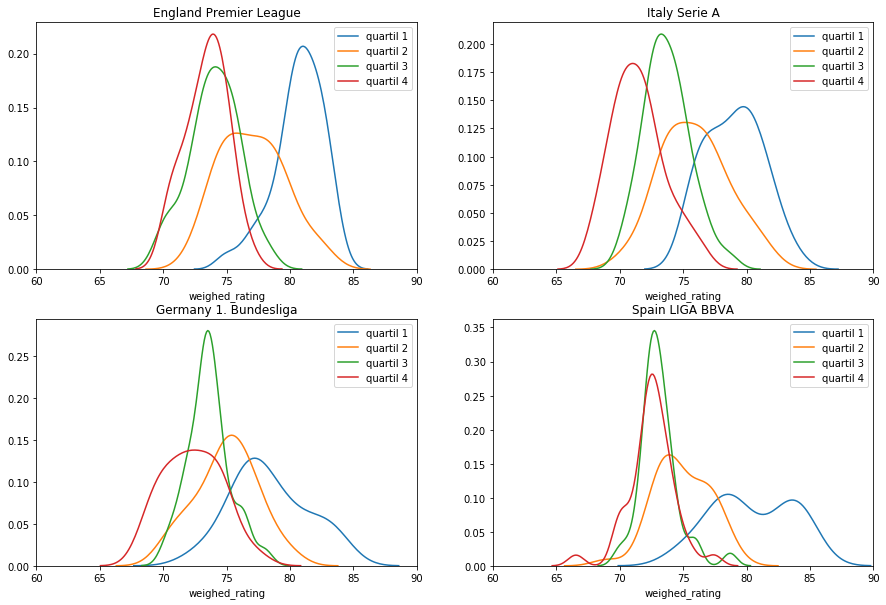

In [44]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
for num, country in enumerate(df_class_rat_4['league_name'].unique()):
  df_league = df_class_rat_4[df_class_rat_4['league_name'] == country]
  ax[num%2,num//2].set_title(country)
  sns.distplot(df_league[df_league['quartile']==1]['weighed_rating'], hist=False, label='quartil 1',
               ax=ax[num%2,num//2])
  sns.distplot(df_league[df_league['quartile']==2]['weighed_rating'], hist=False, label='quartil 2',ax=ax[num%2,num//2])
  sns.distplot(df_league[df_league['quartile']==3]['weighed_rating'], hist=False, label='quartil 3',ax=ax[num%2,num//2])
  sns.distplot(df_league[df_league['quartile']==4]['weighed_rating'], hist=False, label='quartil 4',ax=ax[num%2,num//2])
  ax[num%2,num//2].set_xlim(60,90)

## 5.2 Pregunta 2 - Correlació entre mitjana de punts per partit i qualitat de l'equip

En una primera visualització veiem la baixa correlació entre les dues variables per a totes les lligues.

Text(0.5, 1.0, 'Totes les lligues')

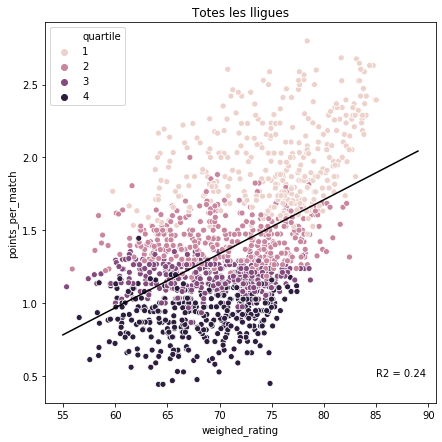

In [46]:
def mod(X,slope, intercept):
  return X * slope + intercept

slope, intercept, r_value, p_value, std_err = stats.linregress(df_classification_rating['weighed_rating'],
                                                               df_classification_rating['points_per_match'])

plt.figure(figsize=(7,7))
sns.scatterplot(x="weighed_rating", y="points_per_match",data=df_classification_rating,
                hue='quartile')
plt.plot(range(55,90), mod(range(55,90),slope, intercept), 'k')
plt.text(85,.5,'R2 = {}'.format(round(r_value**2,2)))
plt.title('Totes les lligues')

En una segona representació d'aquesta correlació, hem agafat les 4 principals lligues que ja hem utilitzat anteriorment per veure la correlació per separat en cada lliga. Gràcies a les grafiques podem corroborar que la lliga espanyola es la que té la correlació més alta i es pot interpretar per la representació dels punts més junts.

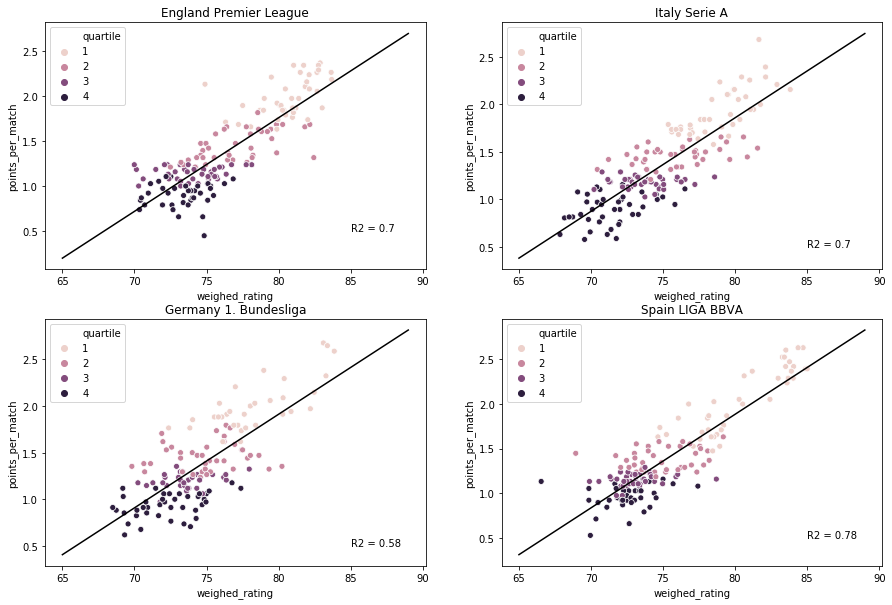

In [47]:
fig, ax = plt.subplots(2,2,figsize=(15,10))
for num, country in enumerate(df_class_rat_4['league_name'].unique()):
  df_league = df_class_rat_4[df_class_rat_4['league_name'] == country]

  slope, intercept, r_value, p_value, std_err = stats.linregress(df_league['weighed_rating'],
                                                                df_league['points_per_match'])

  sns.scatterplot(x="weighed_rating", y="points_per_match",data=df_league,
                  hue='quartile', ax=ax[num%2,num//2])
  ax[num%2,num//2].plot(range(65,90), mod(range(65,90),slope, intercept), 'k')
  ax[num%2,num//2].text(85,.5,'R2 = {}'.format(round(r_value**2,2)))
  ax[num%2,num//2].set_title(country)

## 5.3 Pregunta 3 - Jugadors joves amb perfils semblants a algunes estrelles

A l'anàlisi hem creat clusters per tipus de jugadors i hem extret el TOP5 de jugadors joves que estan al mateix cluster que jugadors com Leo Messi o Andrés Iniesta. A continuació podem veure visualment aquests clusters i on hem identificat alguns dels jugadors més coneguts per ajudar a entendre els perfils de jugadors que engloba els clusters.

In [48]:
# Per a poder visualitzar els grups, reduïm la dimensionalitar de les dades
X_tsne = pd.DataFrame(TSNE(2,learning_rate=200).fit_transform(df_player_attributes_standard),
                      columns=['x','y'])

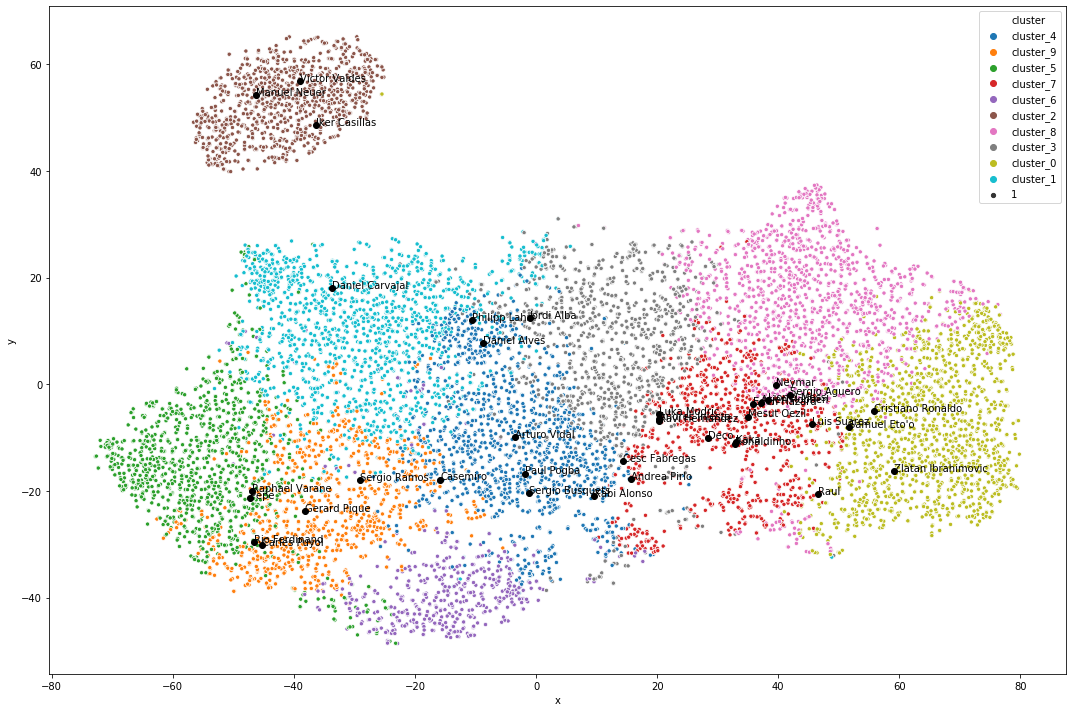

In [49]:
#df_results = df_results.reset_index().join(X_umap)
df_results = df_results.reset_index().join(X_tsne)

plt.figure(figsize=(15,10))
sns.scatterplot(x='x', y='y', data=df_results, hue='cluster',size=1)

names=['Lionel Messi', 'Gerard Pique', 'Xavi Hernandez','Victor Valdes',
      'Andres Iniesta','Iker Casillas','Cristiano Ronaldo','Sergio Busquets',
       'Sergio Ramos','Carles Puyol','Luka Modric', 'Casemiro', 'Luis Suarez',
       "Samuel Eto'o",'Jordi Alba', 'Sergio Aguero', 'Xabi Alonso',
       'Daniel Carvajal','Daniel Alves','Ronaldinho','Neymar','Eden Hazard',
       'Zlatan Ibrahimovic', 'Andrea Pirlo','Mesut Oezil', 'Deco',
       'Cesc Fabregas','Raul', 'Kaka', 'Philipp Lahm', 'Manuel Neuer', 
       'Arturo Vidal', 'Paul Pogba','Arjen Robben', 'Rio Ferdinand',
       'Raphael Varane', 'Pepe',
       ]
for name in names:
  id_pl = df_player[df_player['player_name']==name]['player_api_id'].values[0]
  plt.scatter(df_results[df_results['player_api_id'] == id_pl]['x'],
              df_results[df_results['player_api_id'] == id_pl]['y'],
              c='k', label='Nom Jugador')
  plt.text(df_results[df_results['player_api_id'] == id_pl]['x'],
              df_results[df_results['player_api_id'] == id_pl]['y'],
              name, zorder=10)
plt.tight_layout()

A continuació podrem veure els atributs mitjans de cada perfil de jugador, que correspon a un cluster. Gràcies a un gràfic de radar podem comparar els diferetns perfils.

In [80]:
# Ens quedem amb els atributs que necessitem pel gràfic de radar
df_player_attributes_radar = df_player_attributes_imputed[['pac','sho','pas','dri','def','phy']]
# Reduïm les observacions a un sol registre per jugador i amb la mitjana dels seus atributs
df_player_attributes_radar = df_player_attributes_radar.reset_index().groupby('player_api_id').mean()
# Assignem a quin cluster pertany cada jugador
df_player_attributes_radar = df_player_attributes_radar.merge(
    df_results[['player_api_id','cluster']],
    on='player_api_id',
    how='inner'
)

df_player_attributes_radar

,player_api_id,pac,sho,pas,dri,def,phy,cluster
0,2625,65.071429,53.523810,54.571429,59.128571,58.342857,65.767857,cluster_4
1,2752,41.904762,33.619048,42.087302,49.838095,70.819048,69.988095,cluster_9
2,2768,57.928571,34.301587,48.920635,56.933333,72.676190,66.595238,cluster_5
3,2770,61.000000,67.433333,70.788889,68.320000,41.093333,56.883333,cluster_7
4,2790,71.000000,47.533333,65.033333,65.760000,67.360000,67.700000,cluster_6
...,...,...,...,...,...,...,...,...
11055,744907,65.000000,46.121212,50.287879,60.072727,41.454545,50.840909,cluster_3
11056,746419,76.500000,35.166667,40.166667,65.200000,57.800000,55.750000,cluster_1
11057,748432,66.000000,34.000000,38.833333,46.600000,62.400000,59.250000,cluster_5
11058,750435,64.611111,55.555556,50.000000,62.822222,25.200000,48.750000,cluster_8


In [81]:
# Agrupem per cluster
df_cluster_mean = df_player_attributes_radar.reset_index().groupby('cluster').mean()
# Esborrem les columnes que no necessitem
del df_cluster_mean['index']
del df_cluster_mean['player_api_id']
df_cluster_mean

,pac,sho,pas,dri,def,phy
cluster,,,,,,
cluster_0,69.083362,65.521102,51.991365,64.338786,36.238642,65.838601
cluster_1,71.014176,45.396549,53.982839,63.883303,62.062795,67.695459
cluster_2,45.420808,22.435353,25.055035,39.972859,20.794395,51.543850
cluster_3,71.159098,57.311855,61.091653,67.632114,50.170702,61.715646
cluster_4,66.682377,61.203649,65.368716,67.142325,64.235884,70.140300
cluster_5,62.000942,34.827989,41.628796,53.084022,65.387336,69.335868
cluster_6,64.862346,52.364809,56.193226,61.140458,64.950990,69.066952
cluster_7,70.519523,67.838282,69.983415,71.448697,43.544119,61.655266
cluster_8,78.191857,60.675069,58.020185,70.359245,32.695581,56.845382


In [97]:
import plotly.graph_objects as go

categories = ['PAC','SHO','PAS','DRI','DEF','PHY']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df_cluster_mean.iloc[0],
      theta=categories,
      fill='toself',
      name=df_cluster_mean.iloc[0].name
))
fig.add_trace(go.Scatterpolar(
      r=df_cluster_mean.iloc[1],
      theta=categories,
      fill='toself',
      name=df_cluster_mean.iloc[1].name
))
fig.add_trace(go.Scatterpolar(
      r=df_cluster_mean.iloc[2],
      theta=categories,
      fill='toself',
      name=df_cluster_mean.iloc[2].name
))
fig.add_trace(go.Scatterpolar(
      r=df_cluster_mean.iloc[3],
      theta=categories,
      fill='toself',
      name=df_cluster_mean.iloc[3].name
))
fig.add_trace(go.Scatterpolar(
      r=df_cluster_mean.iloc[4],
      theta=categories,
      fill='toself',
      name=df_cluster_mean.iloc[4].name
))
fig.add_trace(go.Scatterpolar(
      r=df_cluster_mean.iloc[5],
      theta=categories,
      fill='toself',
      name=df_cluster_mean.iloc[5].name
))
fig.add_trace(go.Scatterpolar(
      r=df_cluster_mean.iloc[6],
      theta=categories,
      fill='toself',
      name=df_cluster_mean.iloc[6].name
))
fig.add_trace(go.Scatterpolar(
      r=df_cluster_mean.iloc[7],
      theta=categories,
      fill='toself',
      name=df_cluster_mean.iloc[7].name
))
fig.add_trace(go.Scatterpolar(
      r=df_cluster_mean.iloc[8],
      theta=categories,
      fill='toself',
      name=df_cluster_mean.iloc[8].name
))
fig.add_trace(go.Scatterpolar(
      r=df_cluster_mean.iloc[9],
      theta=categories,
      fill='toself',
      name=df_cluster_mean.iloc[9].name
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[20, 99]
    )),
  showlegend=True
)

fig.show()

# 6. Resolució del problema. A partir dels resultats obtinguts, quines són les conclusions? Els resultats permeten respondre al problema?

Per aquest exercici hem utilitzat un dataset molt complet que ens ha donat diferents possibilitats d'explotació de dades. En el nostre cas hem decidit analitzar les diferencias que hi han entre els equips que queden a la part alta o baixa de la classifiacació i si aquesta posició té relació amb la qualitat dels seus jugadors o es part de l'altazar del joc.

Hem pogut comprobar que aquesta hipotesi es correcte i que els equips que queden en posicions altes es degut a la qualitat dels seus futbolistes. L'explicació més evident és el pressupost que cada equip pot fer per fitxar millors jugadors.

Donada aquesta evidencia, hem fet l'estudi per trobar jugadors joves, que segurament siguin més accesibles per a equips de la part baixa de la classificació, que s'assemblin a jugadors considerats d'alt nivell. Hem pogut veure com jugadors com Raheem Sterling, considerats actualment com dels millors del món (Any 2020), ja ens ha sortit com a futura estrella en l'analisis de la temporada 2015/2016.

# 7. Codi: Cal adjuntar el codi, preferiblement en R, amb el que s’ha realitzat la neteja, anàlisi i representació de les dades. Si ho preferiu, també podeu treballar en Python.

Tot el codi està present en aquest document Jupyter Notebook i es pot execitar seqüencialment pel seu funcionament.